In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/train"
val_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"
test_dir = "/kaggle/input/isic2017-224x224/content/NewISIC17/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 2000
Number of images in validation dataset: 600
Number of images in test dataset: 600


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=96a0ef2c4e453b20ec4567a29b5d6bc4512ebc4e558708ac8b90d683a8accc3d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch.nn as nn
from torchvision.models import swin_t, Swin_T_Weights

class SwinTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinTClassifier, self).__init__()
        # Load the pretrained swin_t model using default weights.
        self.model = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1, progress=True)
        # Replace the classification head.
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [17]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [18]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [19]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [20]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [21]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [22]:
!pip install fvcore

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = SwinTClassifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

        scheduler.step()

    return ensemble_models


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 78.6MB/s] 


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                     | #elements or shape   |
|:-------------------------|:---------------------|
| model                    | 27.5M                |
|  module                  |  27.5M               |
|   module.model           |   27.5M              |
|    module.model.features |    27.5M             |
|    module.model.norm     |    1.5K              |
|    module.model.head     |    2.3K              |
Total FLOPs: 4.51 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


Train Loss: 0.2813, Accuracy: 0.6555, Precision: 0.5366, Recall: 0.6555, F1 Score: 0.5647


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Validation Inference Time: 5.81 sec, Peak GPU Memory: 1409.61 MB
Validation Loss: 0.2882, Accuracy: 0.6900, Precision: 0.6602, Recall: 0.6900, F1 Score: 0.5937
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.2208, Accuracy: 0.7325, Precision: 0.6997, Recall: 0.7325, F1 Score: 0.6875


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.03 sec, Peak GPU Memory: 1518.99 MB
Validation Loss: 0.2514, Accuracy: 0.7167, Precision: 0.7086, Recall: 0.7167, F1 Score: 0.6960
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


Train Loss: 0.1954, Accuracy: 0.7805, Precision: 0.7663, Recall: 0.7805, F1 Score: 0.7541


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Validation Inference Time: 3.31 sec, Peak GPU Memory: 1518.77 MB
Validation Loss: 0.2585, Accuracy: 0.7017, Precision: 0.7480, Recall: 0.7017, F1 Score: 0.7096
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Train Loss: 0.1750, Accuracy: 0.8215, Precision: 0.8141, Recall: 0.8215, F1 Score: 0.8093


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1518.77 MB
Validation Loss: 0.2183, Accuracy: 0.7483, Precision: 0.7512, Recall: 0.7483, F1 Score: 0.7495
Best model updated based on validation accuracy
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.1494, Accuracy: 0.8725, Precision: 0.8687, Recall: 0.8725, F1 Score: 0.8675


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 1517.95 MB
Validation Loss: 0.2297, Accuracy: 0.7467, Precision: 0.7491, Recall: 0.7467, F1 Score: 0.7437
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


Train Loss: 0.1366, Accuracy: 0.8965, Precision: 0.8945, Recall: 0.8965, F1 Score: 0.8935


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.14 sec, Peak GPU Memory: 1517.95 MB
Validation Loss: 0.2592, Accuracy: 0.6917, Precision: 0.7396, Recall: 0.6917, F1 Score: 0.7047
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.1192, Accuracy: 0.9360, Precision: 0.9360, Recall: 0.9360, F1 Score: 0.9346


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1517.95 MB
Validation Loss: 0.2498, Accuracy: 0.7200, Precision: 0.7368, Recall: 0.7200, F1 Score: 0.7250
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.1113, Accuracy: 0.9465, Precision: 0.9466, Recall: 0.9465, F1 Score: 0.9454


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1517.95 MB
Validation Loss: 0.2578, Accuracy: 0.7433, Precision: 0.7655, Recall: 0.7433, F1 Score: 0.7462
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


Train Loss: 0.1015, Accuracy: 0.9720, Precision: 0.9721, Recall: 0.9720, F1 Score: 0.9718


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 1517.95 MB
Validation Loss: 0.2514, Accuracy: 0.7517, Precision: 0.7622, Recall: 0.7517, F1 Score: 0.7500
Best model updated based on validation accuracy
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0973, Accuracy: 0.9825, Precision: 0.9827, Recall: 0.9825, F1 Score: 0.9824


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.19 sec, Peak GPU Memory: 1517.83 MB
Validation Loss: 0.2597, Accuracy: 0.7550, Precision: 0.7528, Recall: 0.7550, F1 Score: 0.7514
Best model updated based on validation accuracy
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0948, Accuracy: 0.9825, Precision: 0.9826, Recall: 0.9825, F1 Score: 0.9824


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1518.28 MB
Validation Loss: 0.2368, Accuracy: 0.7517, Precision: 0.7649, Recall: 0.7517, F1 Score: 0.7554
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0914, Accuracy: 0.9865, Precision: 0.9865, Recall: 0.9865, F1 Score: 0.9864


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 1518.28 MB
Validation Loss: 0.2460, Accuracy: 0.7450, Precision: 0.7522, Recall: 0.7450, F1 Score: 0.7461
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0885, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925, F1 Score: 0.9925


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.17 sec, Peak GPU Memory: 1518.28 MB
Validation Loss: 0.2382, Accuracy: 0.7550, Precision: 0.7525, Recall: 0.7550, F1 Score: 0.7537
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0883, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1518.28 MB
Validation Loss: 0.2435, Accuracy: 0.7750, Precision: 0.7746, Recall: 0.7750, F1 Score: 0.7709
Best model updated based on validation accuracy
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0858, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2350, Accuracy: 0.7717, Precision: 0.7683, Recall: 0.7717, F1 Score: 0.7680
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0862, Accuracy: 0.9920, Precision: 0.9920, Recall: 0.9920, F1 Score: 0.9920


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2336, Accuracy: 0.7350, Precision: 0.7543, Recall: 0.7350, F1 Score: 0.7419
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0847, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925, F1 Score: 0.9925


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2315, Accuracy: 0.7550, Precision: 0.7724, Recall: 0.7550, F1 Score: 0.7612
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0824, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2348, Accuracy: 0.7617, Precision: 0.7632, Recall: 0.7617, F1 Score: 0.7608
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0816, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2380, Accuracy: 0.7617, Precision: 0.7585, Recall: 0.7617, F1 Score: 0.7579
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0803, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2348, Accuracy: 0.7700, Precision: 0.7666, Recall: 0.7700, F1 Score: 0.7644
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0803, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2275, Accuracy: 0.7700, Precision: 0.7649, Recall: 0.7700, F1 Score: 0.7654
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0793, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.10 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2268, Accuracy: 0.7567, Precision: 0.7595, Recall: 0.7567, F1 Score: 0.7577
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0787, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2309, Accuracy: 0.7583, Precision: 0.7551, Recall: 0.7583, F1 Score: 0.7549
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0776, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2284, Accuracy: 0.7617, Precision: 0.7557, Recall: 0.7617, F1 Score: 0.7572
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0766, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2271, Accuracy: 0.7600, Precision: 0.7570, Recall: 0.7600, F1 Score: 0.7574
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0767, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2272, Accuracy: 0.7617, Precision: 0.7578, Recall: 0.7617, F1 Score: 0.7578
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0755, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2261, Accuracy: 0.7650, Precision: 0.7613, Recall: 0.7650, F1 Score: 0.7608
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0749, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2229, Accuracy: 0.7600, Precision: 0.7576, Recall: 0.7600, F1 Score: 0.7575
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0744, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2213, Accuracy: 0.7600, Precision: 0.7576, Recall: 0.7600, F1 Score: 0.7575
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0743, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1517.86 MB
Validation Loss: 0.2202, Accuracy: 0.7600, Precision: 0.7576, Recall: 0.7600, F1 Score: 0.7575
Snapshot 0 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Test Inference Time: 3.24 sec, Peak GPU Memory: 1625.81 MB
Test Loss: 0.2233, Accuracy: 0.7750, Precision: 0.7746, Recall: 0.7750, F1 Score: 0.7709
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       117
           1       0.85      0.87      0.86       393
           2       0.60      0.74      0.66        90

    accuracy                           0.78       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.77      0.78      0.77       600



Test Sensitivity: 0.9342, Test Specificity: 0.5700


<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


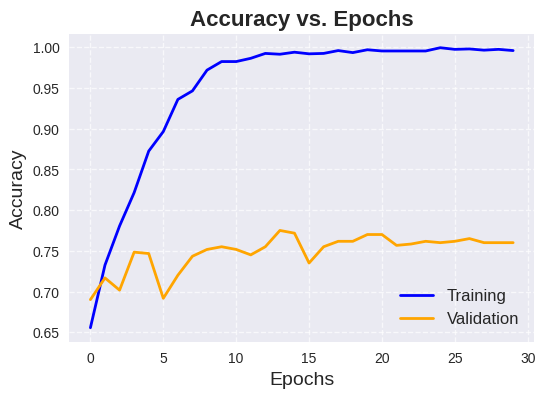

<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


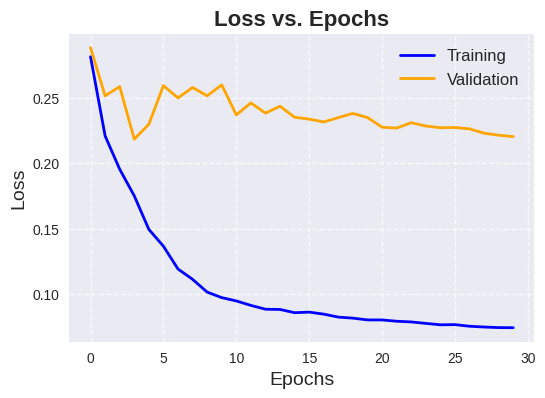

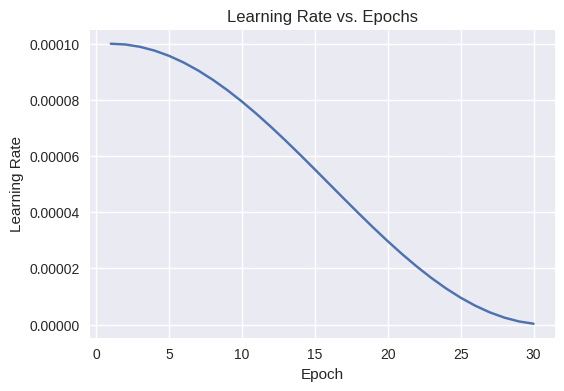

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.1012, Accuracy: 0.9395, Precision: 0.9388, Recall: 0.9395, F1 Score: 0.9389


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2661, Accuracy: 0.7000, Precision: 0.7372, Recall: 0.7000, F1 Score: 0.7056
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0823, Accuracy: 0.9850, Precision: 0.9850, Recall: 0.9850, F1 Score: 0.9850


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.10 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2417, Accuracy: 0.7267, Precision: 0.7477, Recall: 0.7267, F1 Score: 0.7304
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0765, Accuracy: 0.9910, Precision: 0.9910, Recall: 0.9910, F1 Score: 0.9910


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2256, Accuracy: 0.7383, Precision: 0.7465, Recall: 0.7383, F1 Score: 0.7418
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


Train Loss: 0.0742, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2320, Accuracy: 0.7617, Precision: 0.7550, Recall: 0.7617, F1 Score: 0.7571
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0724, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Validation Inference Time: 3.27 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2234, Accuracy: 0.7550, Precision: 0.7558, Recall: 0.7550, F1 Score: 0.7554
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0725, Accuracy: 0.9910, Precision: 0.9910, Recall: 0.9910, F1 Score: 0.9910


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2268, Accuracy: 0.7533, Precision: 0.7474, Recall: 0.7533, F1 Score: 0.7485
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0703, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.04 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2443, Accuracy: 0.7350, Precision: 0.7338, Recall: 0.7350, F1 Score: 0.7296
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0706, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2407, Accuracy: 0.7283, Precision: 0.7508, Recall: 0.7283, F1 Score: 0.7347
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0691, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925, F1 Score: 0.9925


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.03 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2320, Accuracy: 0.7400, Precision: 0.7522, Recall: 0.7400, F1 Score: 0.7413
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0678, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2297, Accuracy: 0.7367, Precision: 0.7514, Recall: 0.7367, F1 Score: 0.7417
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0674, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2455, Accuracy: 0.7350, Precision: 0.7433, Recall: 0.7350, F1 Score: 0.7335
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0673, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2387, Accuracy: 0.7400, Precision: 0.7590, Recall: 0.7400, F1 Score: 0.7408
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0654, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2361, Accuracy: 0.7417, Precision: 0.7446, Recall: 0.7417, F1 Score: 0.7379
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0647, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2236, Accuracy: 0.7600, Precision: 0.7547, Recall: 0.7600, F1 Score: 0.7566
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0633, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2291, Accuracy: 0.7617, Precision: 0.7584, Recall: 0.7617, F1 Score: 0.7594
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0626, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2195, Accuracy: 0.7733, Precision: 0.7664, Recall: 0.7733, F1 Score: 0.7671
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0617, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.19 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2210, Accuracy: 0.7400, Precision: 0.7519, Recall: 0.7400, F1 Score: 0.7424
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


Train Loss: 0.0607, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2222, Accuracy: 0.7417, Precision: 0.7398, Recall: 0.7417, F1 Score: 0.7397
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0609, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2259, Accuracy: 0.7267, Precision: 0.7452, Recall: 0.7267, F1 Score: 0.7316
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0597, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2141, Accuracy: 0.7567, Precision: 0.7560, Recall: 0.7567, F1 Score: 0.7563
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0583, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2185, Accuracy: 0.7550, Precision: 0.7574, Recall: 0.7550, F1 Score: 0.7555
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0573, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Validation Inference Time: 3.23 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2221, Accuracy: 0.7517, Precision: 0.7529, Recall: 0.7517, F1 Score: 0.7508
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.0569, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Validation Inference Time: 3.31 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2193, Accuracy: 0.7533, Precision: 0.7575, Recall: 0.7533, F1 Score: 0.7530
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0558, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2202, Accuracy: 0.7467, Precision: 0.7620, Recall: 0.7467, F1 Score: 0.7512
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0555, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2149, Accuracy: 0.7400, Precision: 0.7390, Recall: 0.7400, F1 Score: 0.7394
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


Train Loss: 0.0547, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.14 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2193, Accuracy: 0.7467, Precision: 0.7507, Recall: 0.7467, F1 Score: 0.7452
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0547, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Validation Inference Time: 3.35 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2256, Accuracy: 0.7333, Precision: 0.7561, Recall: 0.7333, F1 Score: 0.7406
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0534, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Validation Inference Time: 3.22 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2164, Accuracy: 0.7600, Precision: 0.7655, Recall: 0.7600, F1 Score: 0.7615
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0530, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.10 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2134, Accuracy: 0.7567, Precision: 0.7539, Recall: 0.7567, F1 Score: 0.7507
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


Train Loss: 0.0514, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.17 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2136, Accuracy: 0.7433, Precision: 0.7491, Recall: 0.7433, F1 Score: 0.7446
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0510, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2163, Accuracy: 0.7367, Precision: 0.7466, Recall: 0.7367, F1 Score: 0.7377
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0505, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.19 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2118, Accuracy: 0.7467, Precision: 0.7578, Recall: 0.7467, F1 Score: 0.7498
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0493, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2089, Accuracy: 0.7383, Precision: 0.7436, Recall: 0.7383, F1 Score: 0.7396
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0489, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Validation Inference Time: 3.01 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2082, Accuracy: 0.7450, Precision: 0.7466, Recall: 0.7450, F1 Score: 0.7441
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0480, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2066, Accuracy: 0.7417, Precision: 0.7443, Recall: 0.7417, F1 Score: 0.7414
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0478, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2050, Accuracy: 0.7433, Precision: 0.7486, Recall: 0.7433, F1 Score: 0.7443
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.0466, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Validation Inference Time: 3.43 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2036, Accuracy: 0.7433, Precision: 0.7480, Recall: 0.7433, F1 Score: 0.7441
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Train Loss: 0.0462, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2022, Accuracy: 0.7467, Precision: 0.7498, Recall: 0.7467, F1 Score: 0.7468
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Train Loss: 0.0453, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Validation Inference Time: 3.72 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.2008, Accuracy: 0.7467, Precision: 0.7498, Recall: 0.7467, F1 Score: 0.7468
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Train Loss: 0.0445, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Validation Inference Time: 3.31 sec, Peak GPU Memory: 1626.57 MB
Validation Loss: 0.1992, Accuracy: 0.7467, Precision: 0.7498, Recall: 0.7467, F1 Score: 0.7468
Snapshot 1 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Test Inference Time: 3.38 sec, Peak GPU Memory: 1733.62 MB
Test Loss: 0.1724, Accuracy: 0.7750, Precision: 0.7746, Recall: 0.7750, F1 Score: 0.7709
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       117
           1       0.85      0.87      0.86       393
           2       0.60      0.74      0.66        90

    accuracy                           0.78       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.77      0.78      0.77       600



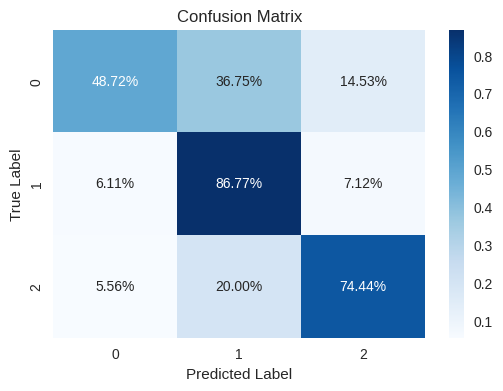

Test Sensitivity: 0.9342, Test Specificity: 0.5700


<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


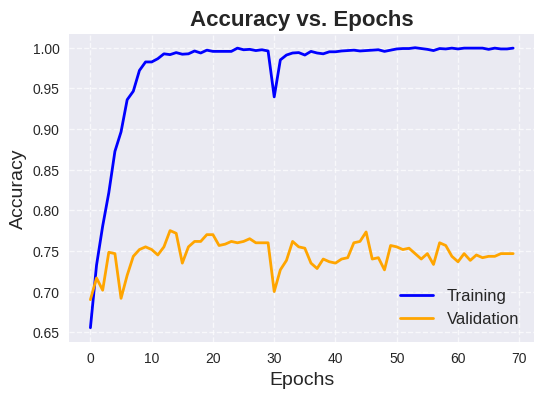

<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


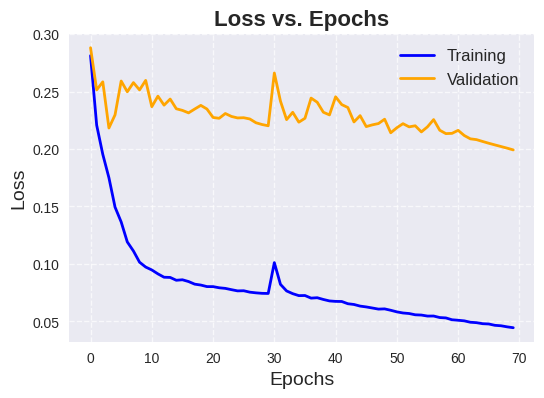

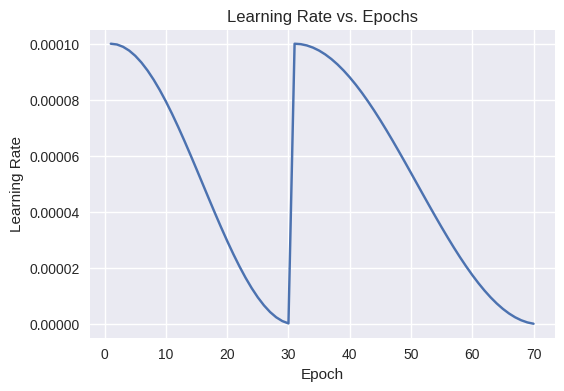

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0589, Accuracy: 0.9745, Precision: 0.9744, Recall: 0.9745, F1 Score: 0.9743


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2241, Accuracy: 0.7317, Precision: 0.7357, Recall: 0.7317, F1 Score: 0.7175
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0577, Accuracy: 0.9710, Precision: 0.9708, Recall: 0.9710, F1 Score: 0.9709


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1864, Accuracy: 0.7683, Precision: 0.7693, Recall: 0.7683, F1 Score: 0.7601
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0514, Accuracy: 0.9865, Precision: 0.9865, Recall: 0.9865, F1 Score: 0.9865


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Validation Inference Time: 2.99 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2024, Accuracy: 0.7483, Precision: 0.7652, Recall: 0.7483, F1 Score: 0.7442
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0490, Accuracy: 0.9890, Precision: 0.9890, Recall: 0.9890, F1 Score: 0.9890


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2133, Accuracy: 0.7067, Precision: 0.7351, Recall: 0.7067, F1 Score: 0.7156
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0465, Accuracy: 0.9945, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1969, Accuracy: 0.7383, Precision: 0.7333, Recall: 0.7383, F1 Score: 0.7345
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0459, Accuracy: 0.9910, Precision: 0.9910, Recall: 0.9910, F1 Score: 0.9910


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2092, Accuracy: 0.7200, Precision: 0.7343, Recall: 0.7200, F1 Score: 0.7248
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0466, Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1 Score: 0.9860


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Validation Inference Time: 3.28 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1855, Accuracy: 0.7517, Precision: 0.7662, Recall: 0.7517, F1 Score: 0.7571
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.0441, Accuracy: 0.9915, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.17 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1861, Accuracy: 0.7583, Precision: 0.7618, Recall: 0.7583, F1 Score: 0.7586
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0423, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2077, Accuracy: 0.7267, Precision: 0.7439, Recall: 0.7267, F1 Score: 0.7289
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0415, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1966, Accuracy: 0.7400, Precision: 0.7612, Recall: 0.7400, F1 Score: 0.7465
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0426, Accuracy: 0.9895, Precision: 0.9895, Recall: 0.9895, F1 Score: 0.9895


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Validation Inference Time: 3.23 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2137, Accuracy: 0.7167, Precision: 0.7520, Recall: 0.7167, F1 Score: 0.7271
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0399, Accuracy: 0.9940, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2215, Accuracy: 0.7000, Precision: 0.7252, Recall: 0.7000, F1 Score: 0.7068
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0371, Accuracy: 0.9965, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1919, Accuracy: 0.7617, Precision: 0.7589, Recall: 0.7617, F1 Score: 0.7555
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0369, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1931, Accuracy: 0.7700, Precision: 0.7633, Recall: 0.7700, F1 Score: 0.7556
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.0354, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2104, Accuracy: 0.7267, Precision: 0.7446, Recall: 0.7267, F1 Score: 0.7295
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0346, Accuracy: 0.9960, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1959, Accuracy: 0.7433, Precision: 0.7503, Recall: 0.7433, F1 Score: 0.7455
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0340, Accuracy: 0.9950, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Validation Inference Time: 3.23 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2135, Accuracy: 0.7033, Precision: 0.7497, Recall: 0.7033, F1 Score: 0.7165
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0339, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.07 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2015, Accuracy: 0.7133, Precision: 0.7305, Recall: 0.7133, F1 Score: 0.7199
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0319, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1934, Accuracy: 0.7500, Precision: 0.7631, Recall: 0.7500, F1 Score: 0.7549
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0305, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.17 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2010, Accuracy: 0.7333, Precision: 0.7449, Recall: 0.7333, F1 Score: 0.7338
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0302, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1916, Accuracy: 0.7450, Precision: 0.7427, Recall: 0.7450, F1 Score: 0.7413
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Train Loss: 0.0297, Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Validation Inference Time: 3.29 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1884, Accuracy: 0.7433, Precision: 0.7460, Recall: 0.7433, F1 Score: 0.7426
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0284, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1837, Accuracy: 0.7567, Precision: 0.7580, Recall: 0.7567, F1 Score: 0.7540
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0279, Accuracy: 0.9970, Precision: 0.9970, Recall: 0.9970, F1 Score: 0.9970


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1861, Accuracy: 0.7517, Precision: 0.7506, Recall: 0.7517, F1 Score: 0.7490
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0270, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1888, Accuracy: 0.7617, Precision: 0.7645, Recall: 0.7617, F1 Score: 0.7534
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0256, Accuracy: 0.9980, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1917, Accuracy: 0.7333, Precision: 0.7403, Recall: 0.7333, F1 Score: 0.7341
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


Train Loss: 0.0248, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.10 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2091, Accuracy: 0.7250, Precision: 0.7373, Recall: 0.7250, F1 Score: 0.7254
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0237, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1969, Accuracy: 0.7233, Precision: 0.7360, Recall: 0.7233, F1 Score: 0.7280
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0224, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1960, Accuracy: 0.7283, Precision: 0.7531, Recall: 0.7283, F1 Score: 0.7363
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0219, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1924, Accuracy: 0.7333, Precision: 0.7477, Recall: 0.7333, F1 Score: 0.7384
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0209, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1964, Accuracy: 0.7217, Precision: 0.7453, Recall: 0.7217, F1 Score: 0.7292
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0210, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Validation Inference Time: 3.19 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1968, Accuracy: 0.7250, Precision: 0.7483, Recall: 0.7250, F1 Score: 0.7324
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0190, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1909, Accuracy: 0.7367, Precision: 0.7449, Recall: 0.7367, F1 Score: 0.7379
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0186, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1922, Accuracy: 0.7267, Precision: 0.7452, Recall: 0.7267, F1 Score: 0.7333
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0172, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1879, Accuracy: 0.7433, Precision: 0.7546, Recall: 0.7433, F1 Score: 0.7478
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0161, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1848, Accuracy: 0.7483, Precision: 0.7482, Recall: 0.7483, F1 Score: 0.7481
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0154, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1925, Accuracy: 0.7350, Precision: 0.7545, Recall: 0.7350, F1 Score: 0.7418
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0146, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Validation Inference Time: 3.29 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1887, Accuracy: 0.7433, Precision: 0.7547, Recall: 0.7433, F1 Score: 0.7470
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0136, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Validation Inference Time: 3.06 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1898, Accuracy: 0.7400, Precision: 0.7420, Recall: 0.7400, F1 Score: 0.7388
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


Train Loss: 0.0126, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.16 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1911, Accuracy: 0.7533, Precision: 0.7466, Recall: 0.7533, F1 Score: 0.7448
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0116, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.04 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1982, Accuracy: 0.7333, Precision: 0.7465, Recall: 0.7333, F1 Score: 0.7366
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0107, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1986, Accuracy: 0.7367, Precision: 0.7481, Recall: 0.7367, F1 Score: 0.7398
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0096, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Validation Inference Time: 3.07 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1990, Accuracy: 0.7333, Precision: 0.7440, Recall: 0.7333, F1 Score: 0.7350
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0088, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Validation Inference Time: 3.09 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2004, Accuracy: 0.7383, Precision: 0.7486, Recall: 0.7383, F1 Score: 0.7399
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0078, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.2006, Accuracy: 0.7383, Precision: 0.7496, Recall: 0.7383, F1 Score: 0.7410
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Train Loss: 0.0068, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Validation Inference Time: 3.04 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1984, Accuracy: 0.7417, Precision: 0.7495, Recall: 0.7417, F1 Score: 0.7423
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Train Loss: 0.0061, Accuracy: 0.9985, Precision: 0.9985, Recall: 0.9985, F1 Score: 0.9985


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Validation Inference Time: 3.11 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1986, Accuracy: 0.7417, Precision: 0.7500, Recall: 0.7417, F1 Score: 0.7429
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0047, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995, F1 Score: 0.9995


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1984, Accuracy: 0.7400, Precision: 0.7495, Recall: 0.7400, F1 Score: 0.7420
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Train Loss: 0.0037, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1979, Accuracy: 0.7383, Precision: 0.7472, Recall: 0.7383, F1 Score: 0.7399
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Train Loss: 0.0031, Accuracy: 0.9990, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Validation Inference Time: 3.17 sec, Peak GPU Memory: 1734.20 MB
Validation Loss: 0.1973, Accuracy: 0.7383, Precision: 0.7472, Recall: 0.7383, F1 Score: 0.7399
Snapshot 2 saved


Testing: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

Test Inference Time: 3.07 sec, Peak GPU Memory: 1842.83 MB
Test Loss: 0.1243, Accuracy: 0.7750, Precision: 0.7746, Recall: 0.7750, F1 Score: 0.7709
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       117
           1       0.85      0.87      0.86       393
           2       0.60      0.74      0.66        90

    accuracy                           0.78       600
   macro avg       0.70      0.70      0.69       600
weighted avg       0.77      0.78      0.77       600



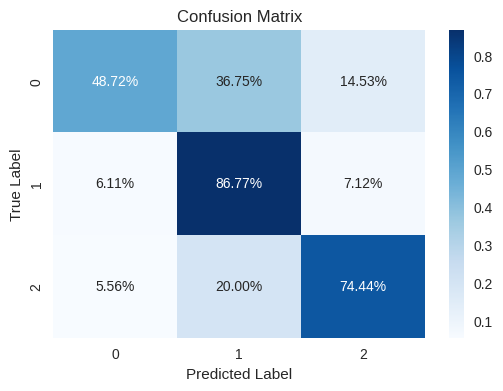

<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


Test Sensitivity: 0.9342, Test Specificity: 0.5700


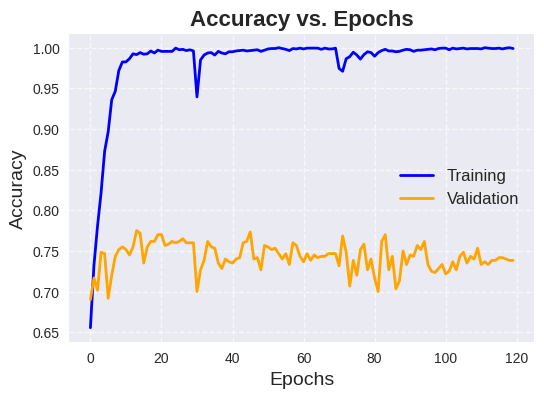

<ipython-input-19-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


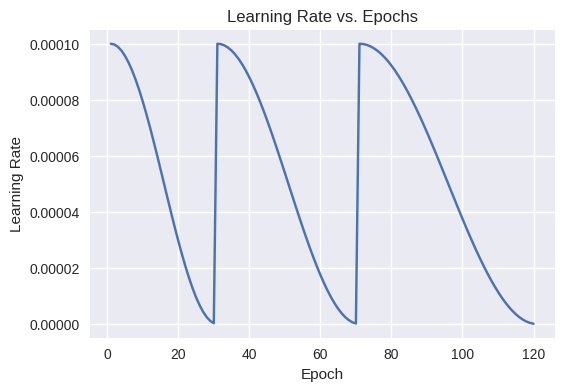

In [24]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)